In [244]:
import pandas as pd
import numpy as np

In [245]:
file = open('beerguide.txt', 'rt')
lines = file.readlines()
file.close()

lines[:] = [element for element in lines if element != '\n' ]
lines = [i.split('\n', 1)[0] for i in lines]

In [246]:
#Get the list of all 79 beers
a = lines.index('Table of Contents')
b = lines.index('Specialty Beer')

beerlist = lines[a:b+1]
beerlist[:] = [element for element in beerlist if '\ue004' not in element][1:]

In [247]:
#Replace irregular characters produced from converting pdf
word_replace_dict = {'\xa0': ' ', 
                     '\xad': '-',
                     '\x0c':'',
                    '\ue000':'B',
                    '\ue001':'E',
                    '\ue002':'S',
                    '\ue004':'s',
                    '\ue006':'y'}
beerdes = lines[b+1:]

for k,v in word_replace_dict.items():
    beerdes = [word.replace(k,v) for word in beerdes]

In [248]:
#List all the features we want to include in the model
feature = ['IBU', 'BU:GU', 'CO2 Volumes', 'Apparent Attenuation', 'Alcohol', 
             'Collar of Foam (Head Retention)', 'Collar of Foam (Texture)',
            'Hop Aroma/Flavor', 'Hop bitterness','Malt Aroma/Flavor',
            'Palate Body', 'Palate Carbonation', 'Palate Length/Finish', 'Esters']

In [249]:
#Create a dictionary that lists values for all the features
def beer_info(beer,character):
    l = []
    for i in range(len(character)):
        if character[i] == 'Alcohol':
            l.append([beer [beer.index('Alcohol')+1]][0])
        
        else:
            a = [element for element in beer if character[i] in element]
            if a:
                l.append(a[0].split(character[i],1)[1])
            else:
                l.append(np.nan)
               
    return l

In [250]:
# %debug
beer_dic = {}

for j in range(len(beerlist)):
    if j == len(beerlist)-1:
        b = beerdes[beerdes.index(beerlist[j]):]
    else:
        b = beerdes[beerdes.index(beerlist[j]):beerdes.index(beerlist[j+1])]
    beer_dic[beerlist[j]] = beer_info(beer = b, character = feature)

In [251]:
#Convert dictionary to dataframe
data = pd.DataFrame(beer_dic, index= feature).transpose()
data.fillna('None', inplace = True)

#Fix a few lost values from converting pdf
data.loc['Bohemian-Style Pilsener'].IBU = '30 - 45'
data.loc['Bohemian-Style Pilsener']['Hop bitterness'] = 'medium'

In [252]:
df = data.copy()

In [253]:
# for i in df.columns:
#     print(i, '\n', df[i].unique())

In [254]:
###Feature Engineering


#Clean IBU, BU:GU, Apparent Attenuation
#Use mid-point of the range
#If varies, use most frequent value

df['IBU'] = df['IBU'].str.strip()
df_IBU_most_freq = df['IBU'].loc[df['IBU'] != 'Varies'].value_counts().idxmax()
df['IBU'].loc[df['IBU'] == 'Varies'] = df_IBU_most_freq
df['IBU'] = (df.IBU.str.split(' ').str[0].astype(float) + df.IBU.str.split(' ').str[2].astype(float))/2

df['BU:GU'] = df['BU:GU'].str.strip()
df_BUGU_most_freq = df['BU:GU'].loc[df['BU:GU'] != 'Varies'].value_counts().idxmax()
df['BU:GU'].loc[df['BU:GU'] == 'Varies'] = '0.5 - 0.5'
df['BU:GU'] = (df['BU:GU'].str.split(' ').str[0].astype(float) + df['BU:GU'].str.split(' ').str[2].astype(float))/2

df['Apparent Attenuation'] = df['Apparent Attenuation'].str.strip()
df_att_most_freq = df['Apparent Attenuation'].loc[df['Apparent Attenuation'] != 'Varies'].value_counts().idxmax()
df['Apparent Attenuation'].loc[df['Apparent Attenuation'] == 'Varies'] = '50 - 50'
df['Apparent Attenuation'] = (df['Apparent Attenuation'].str.split(' ').str[0].astype(float) + df['Apparent Attenuation'].str.split(' ').str[2].astype(float))/2

#Clean CO2 Volumes
#Use mid-point of the range
#If varies, use most frequent value
#If approximately, use the approximation value

df['CO2 Volumes'] = df['CO2 Volumes'].str.strip()
df_CO2_most_freq = df['CO2 Volumes'].loc[df['CO2 Volumes'] != 'Varies'].value_counts().idxmax()
df['CO2 Volumes'].loc[df['CO2 Volumes'] == 'Varies'] = '2.5 - 2.5'
df['CO2 Volumes'] = df['CO2 Volumes'].str.replace(r'\b approximately', '')

CO2_1st_all = df['CO2 Volumes'].str.split(' ').str[0].astype(float)
CO2_3rd_all = df['CO2 Volumes'].str.split(' ').str[2].astype(float)
CO2_1st_no_nan = df['CO2 Volumes'].loc[CO2_3rd_all.isnull() == False].str.split(' ').str[0].astype(float)
CO2_3rd_no_nan = df['CO2 Volumes'].loc[CO2_3rd_all.isnull() == False].str.split(' ').str[2].astype(float)

df['CO2 Volumes'].loc[CO2_3rd_all.isnull() == True] = CO2_1st_all
df['CO2 Volumes'].loc[CO2_3rd_all.isnull() == False] = (CO2_1st_no_nan + CO2_3rd_no_nan) / 2

/Users/Mengfei/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [255]:
#Alcohol: Not detectable, Mild, Noticeable, Harsh/Hot， Varies
#Create binary columns for each value
i = 'Alcohol'
c = {'Not_Det':['not detectable'], 'Mild':['mild'], 'Noticeable':['noticeable'], 'Varies':['varies'], 
     'Harsh':['hot', 'harsh']}

for k,v in c.items():
    df['Alcohol_' + k] = [1 if any(x in df[i][w].lower() for x in c[k]) else 0 for w in range(len(df))]
df.drop(i,1,inplace = True)

#Collar of Foam (Head Retention): Poor, Moderate, Good, Varies
#Create binary columns for each value
i = 'Collar of Foam (Head Retention)'
c = {'Poor':['poor'], 'Mod':['moderate'], 'Good':['good'], 'Varies':['varies']}

for k,v in c.items():
    df['Foam_Head_Ret_' + k] = [1 if any(x in df[i][w].lower() for x in c[k]) else 0 for w in range(len(df))]
df.drop(i,1,inplace = True)


#Collar of Foam (Texture): Thin, Interrupted, Foamy, Fluffy, Rocky, Mousse-like, Varies
#Create binary columns for each value
i = 'Collar of Foam (Texture)'
c = {'Thin':['thin'], 'Intrpt':['interrupted'],'Foamy':['foam'], 'Fluffy':['fluf'], 'Rocky':['rock'],
    'Mousse':['mous'], 'Varies':['varies']}

for k,v in c.items():
    df['Foam_Texture_' + k] = [1 if any(x in df[i][w].lower() for x in c[k]) else 0 for w in range(len(df))]
df.drop(i,1,inplace = True)

#Palate Body: Drying, Soft, Moderate, Mouth-Coating, Sticky, Varies
#Create binary columns for each value
i = 'Palate Body'
c = {'Drying':['dry'], 'Soft':['soft'], 'Mod':['moderate'], 'Mthct':['mouth-coating'], 'Sticky':['stick'], 
     'Varies':['varies']}

for k,v in c.items():
    df['Pt_Body_' + k] = [1 if any(x in df[i][w].lower() for x in c[k]) else 0 for w in range(len(df))]
df.drop(i,1,inplace = True)

#Palate Carbonation: Very Low, Low, Medium, High
#Create binary columns for each value
i = 'Palate Carbonation'
c = {'VLow':['very low'], 'Low':['low'], 'Med':['medium'], 'High':['high']}

for k,v in c.items():
    df['Pt_Carb_' + k] = [1 if any(x in df[i][w].lower() for x in c[k]) else 0 for w in range(len(df))]

df.drop(i,1,inplace = True)


#Palate Length/Finish: Short, Medium, Long, Varies
#Create binary columns for each value

i = 'Palate Length/Finish'
c = {'Short':['short'], 'Med':['medium'], 'Long':['long'], 'Varies':['varies']}

for k,v in c.items():
    df['Pt_Len_' + k] = [1 if any(x in df[i][w].lower() for x in c[k]) else 0 for w in range(len(df))]

df.drop(i,1,inplace = True)    

#Esters: Fruit(Citrus, Orange, Lemon, Banana, Cherry, Pear, Apple, Grape, Plum, Prune), Smoke/Smoky 
    #Date, Fig, Pine, Raisin
#Create binary columns for each value
i = 'Esters'
c = {'Fruit':['fruit', 'citrus','orange','lemon','banana','cherry','pear','apple','grape','plum','prune', 'fig'],
    'Smoke':['smok'], 'Date':['date'], 'Pine':['pine'], 'Raisin':['raisin']}

for k,v in c.items():
    df['Esters' + k] = [1 if any(x in df[i][w].lower() for x in c[k]) else 0 for w in range(len(df))]

df.drop(i,1,inplace = True)
    
#Hop bitterness: very low (minimal), low, medium, high
#Create binary columns for each value
i = 'Hop bitterness'

c = {'minimal':['None,','absent', 'not perceived', 'very low', 'minimal', 'not perceived'], 
     'low':['low'], 'medium':['medium', 'moderate'], 'high':['high','strong']}

for k,v in c.items():
    df['Hopbit_' + k] = [1 if any(x in df[i][w].lower() for x in c[k]) else 0 for w in range(len(df))]

df.drop(i,1,inplace = True)
#Hop aroma: Citrus, Fruity, Floral, Fresh, Herbal, woody, chocolate; very low (minimal), low, medium, high

i = 'Hop Aroma/Flavor'
c = {'minimal':['None,','absent', 'not perceived', 'very low', 'minimal', 'not perceived'], 
     'low':['low'], 'medium':['medium', 'moderate'], 'high':['high','strong'],
    'flower':['flower','floral'], 'herb':['herb'], 'citrus':['citrus'], 'choco':['choco','cocoa'], 
    'wood':['wood'],'fresh': ['fresh']}

for k,v in c.items():
    df['Hop_AF_' + k] = [1 if any(x in df[i][w].lower() for x in c[k]) else 0 for w in range(len(df))]
df.drop(i,1,inplace = True) 

#Malt Aroma Flavor 
i = 'Malt Aroma/Flavor'
c = {'choco': ['choco', 'cocoa'], 'caramel' : ['caram', 'toffee'], 'burnt':['burnt'], 'varies':['varies'], 
     'wheat':['wheat', 'bread', 'toast'], 
     'sweet': ['sweet'], 'dry':['dry']}

for k,v in c.items():
    df['MaltAF_' + k] = [1 if any(x in df[i][w].lower() for x in c[k]) else 0 for w in range(len(df))] 
df.drop(i,1,inplace = True)


In [256]:
for i in df.columns:
    print(i, '\n', df[i].unique())

IBU 
 [ 35.   24.   80.   60.   25.   16.   42.5  70.   65.   10.   40.   47.5
  22.5  37.5  27.5  11.5  18.   29.   32.5  13.5   4.5  20.   50.   30.
  12.5  49.   17.   26.   38.5  22.   20.5  21.5  23.   50.5  82.5]
BU:GU 
 [ 0.7    0.485  0.75   0.91   0.5    0.685  0.325  0.88   0.47   0.77   0.71
  0.22   0.84   0.45   0.61   0.48   0.36   0.365  0.215  0.335  0.415
  0.305  0.505  0.39   0.285  0.15   0.74   0.79   0.43   0.455  0.275
  0.765  0.44   0.55   0.84   0.62   0.63   0.605  0.355  0.405  0.785
  0.24   0.65   0.54   0.335  0.265  0.47   0.935  0.81   0.615  0.38   0.4
  0.58   0.51   0.49 ]
CO2 Volumes 
 [2.25 2.5 2.45 2.75 3.5 4.0 1.25 3.25 3.75 1.75 3.9 2.0]
Apparent Attenuation 
 [ 72.     75.     77.5    50.     72.5    86.     78.     73.5    77.915
  77.     75.5    78.5    73.     81.5    79.5    76.5    79.     91.     83.
  84.5    83.5    66.     74.5    78.14   76.     74.     82.5    71.5    71.
  68.5    70.5    69.5    82.   ]
Alcohol_Not_Det 
 [0 1]
Alc

Cophenetic Correlation Coefficient using average clustering method is 0.85.


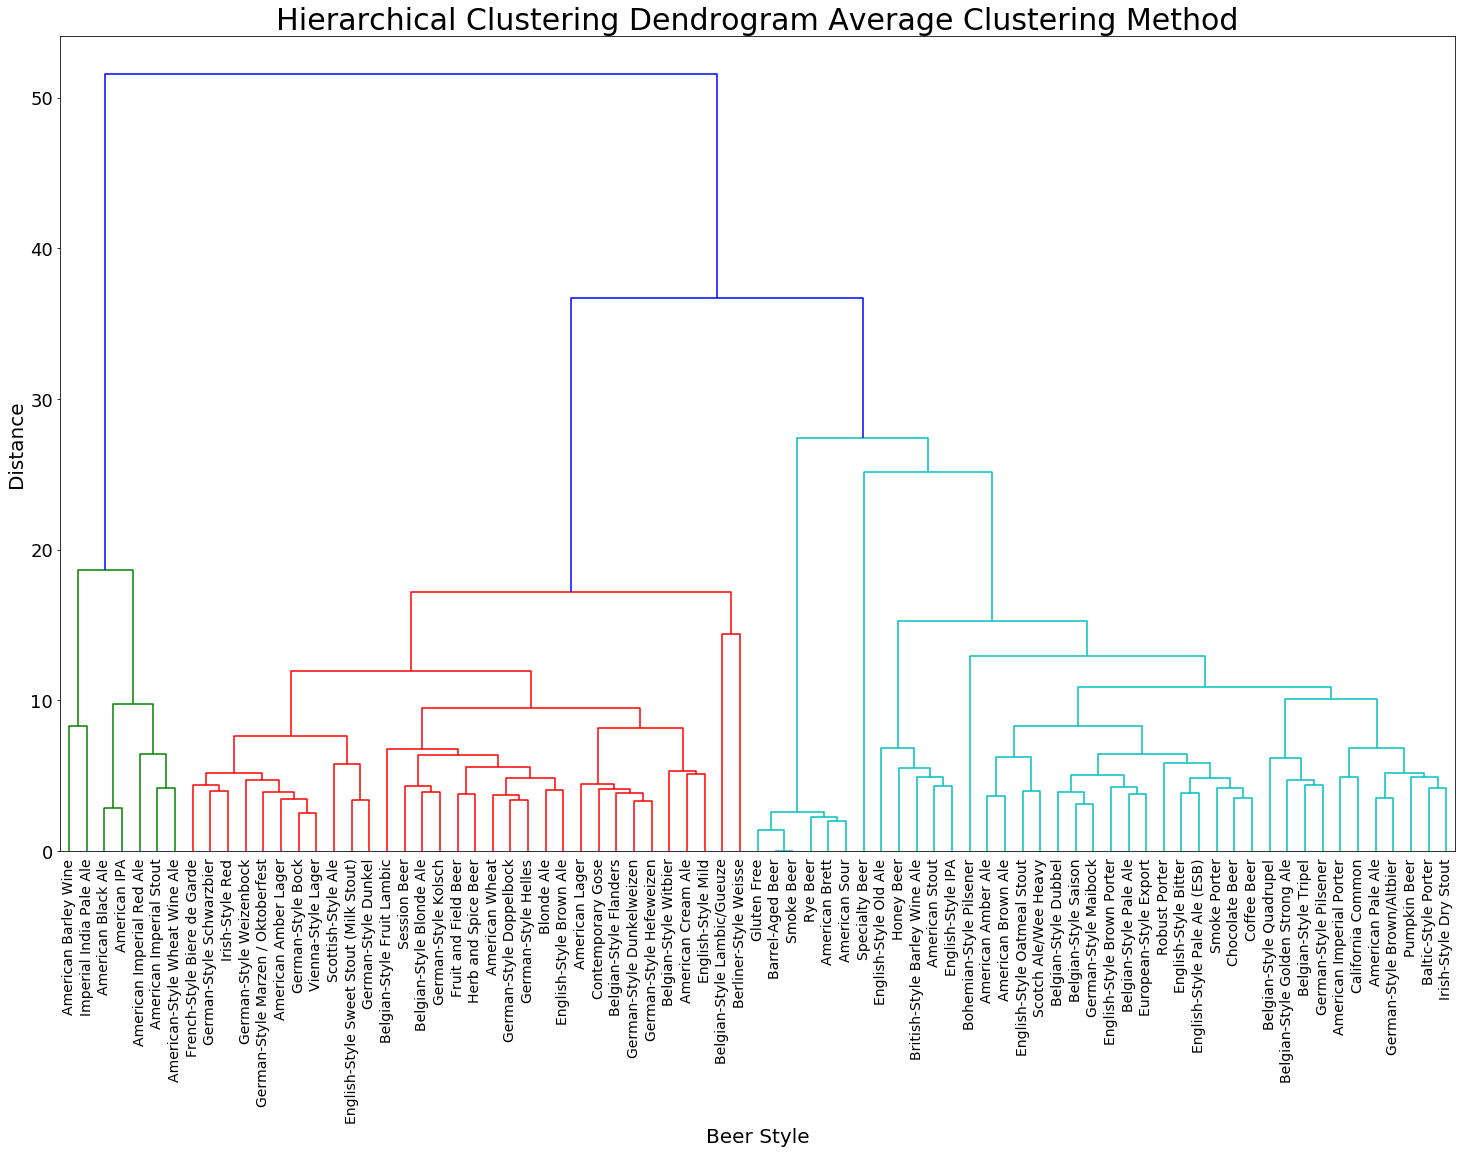

Cophenetic Correlation Coefficient using centroid clustering method is 0.80.


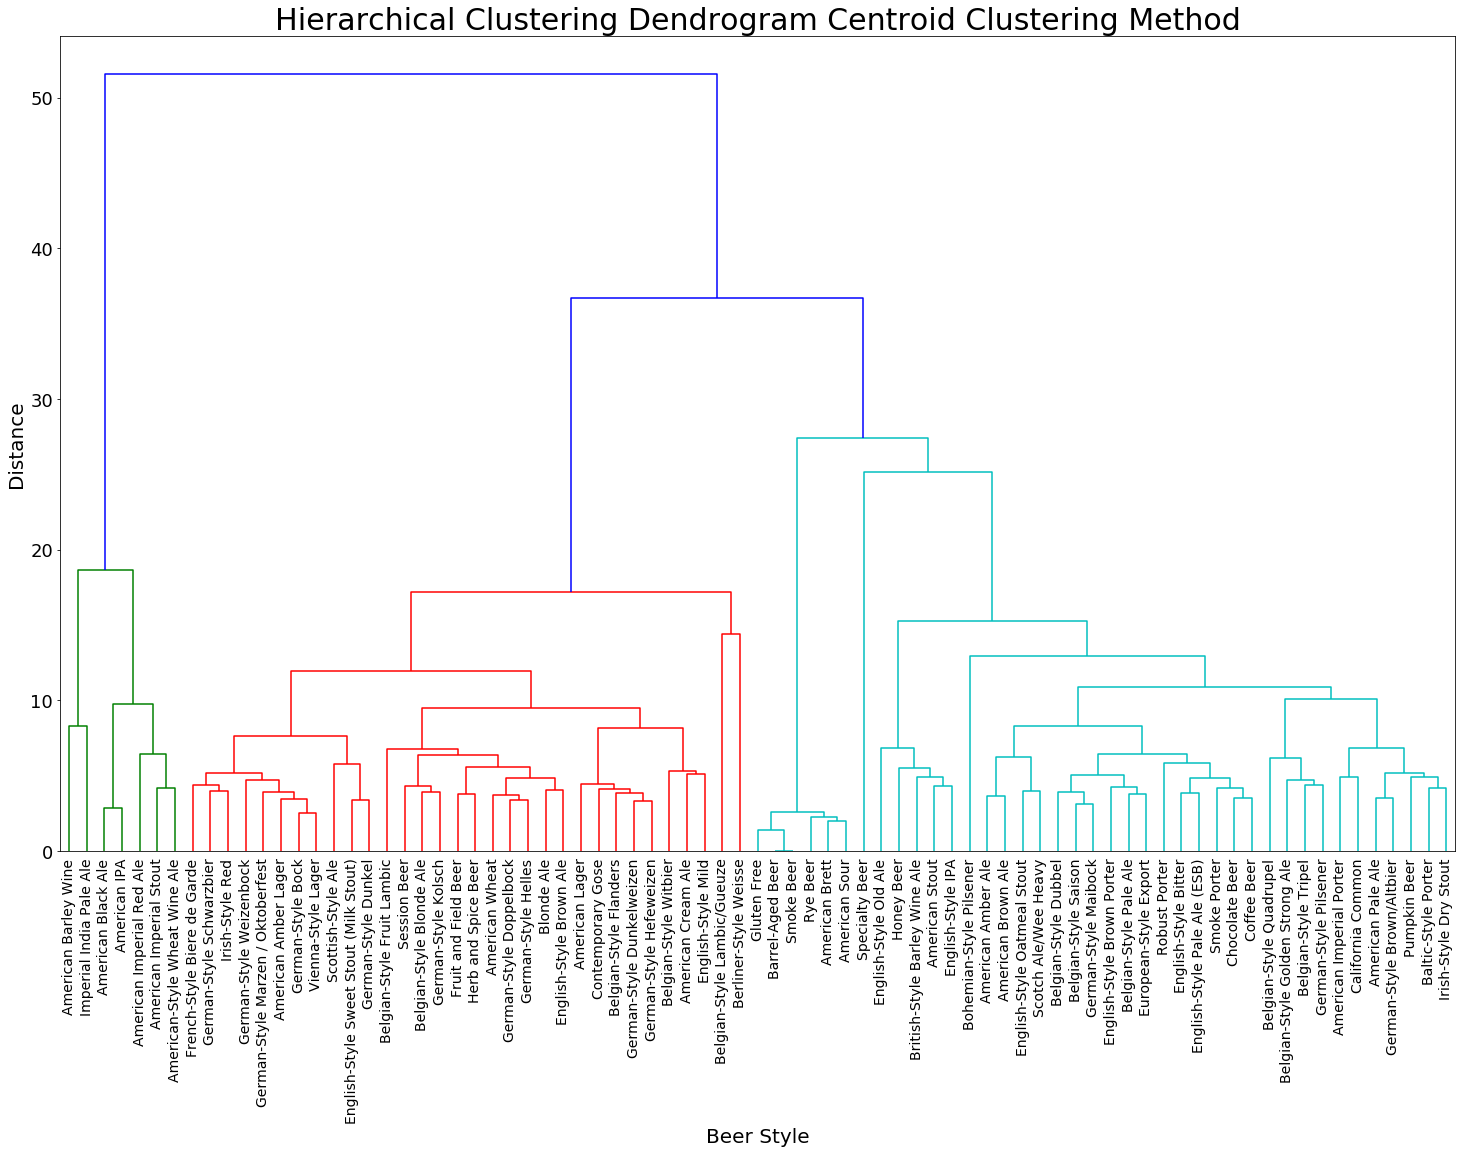

Cophenetic Correlation Coefficient using ward clustering method is 0.66.


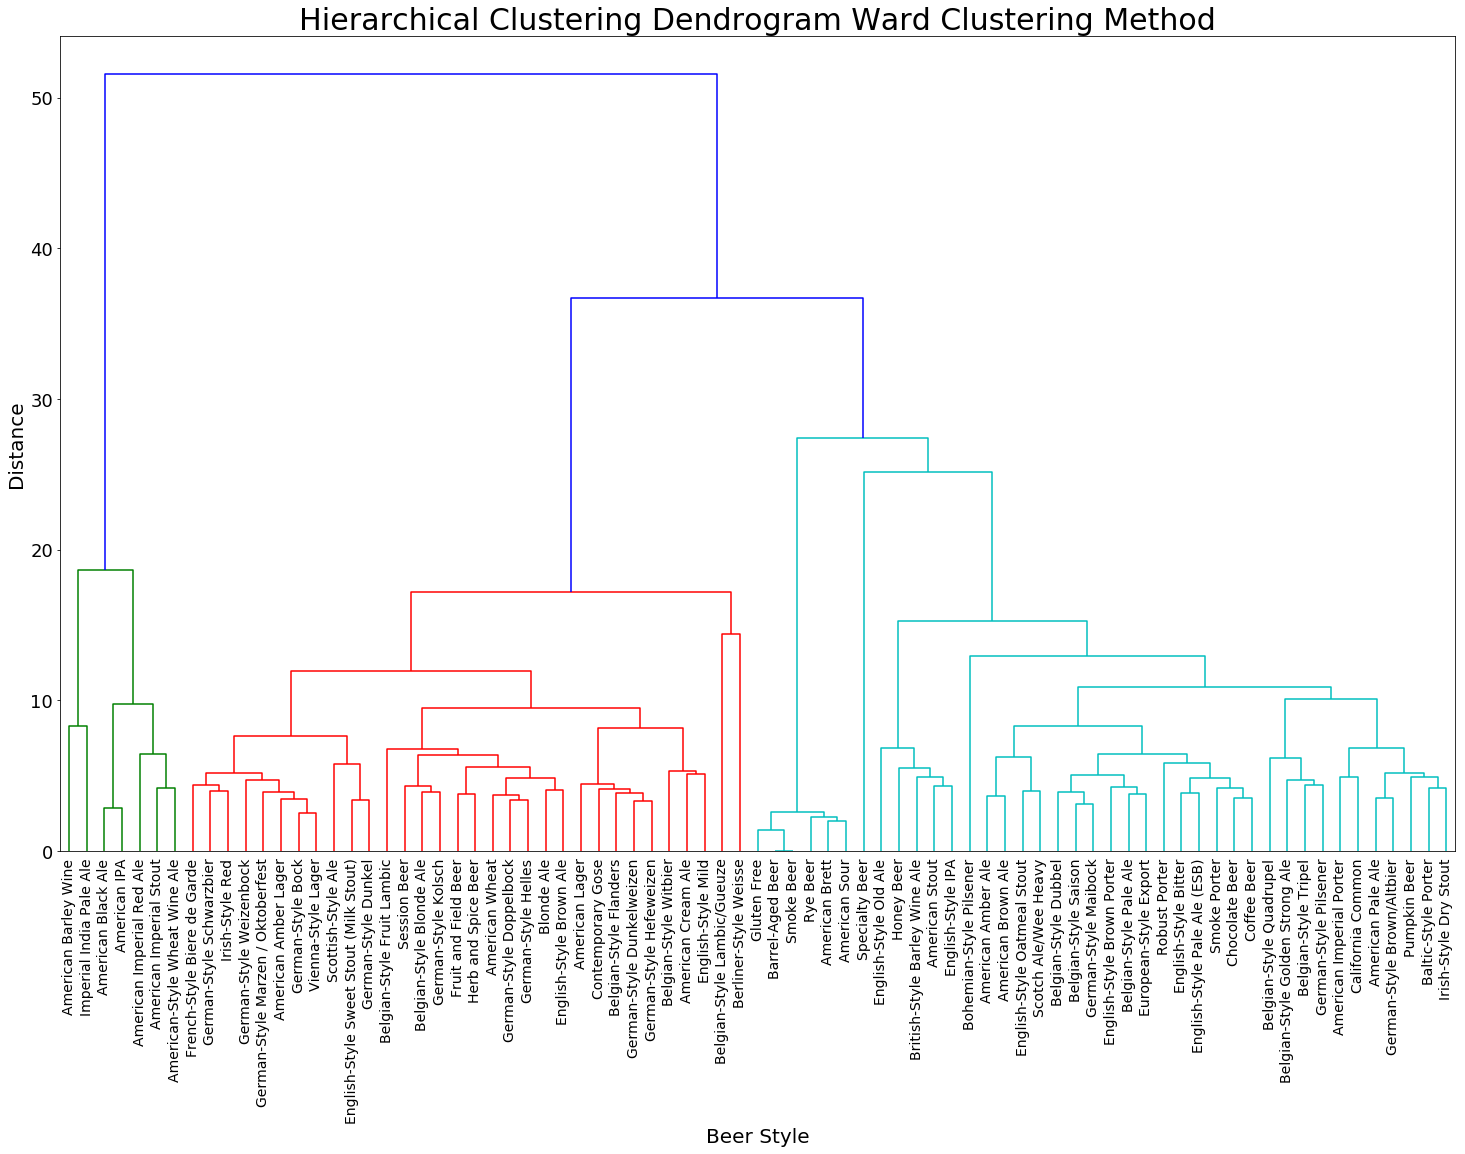

Cophenetic Correlation Coefficient using complete clustering method is 0.69.


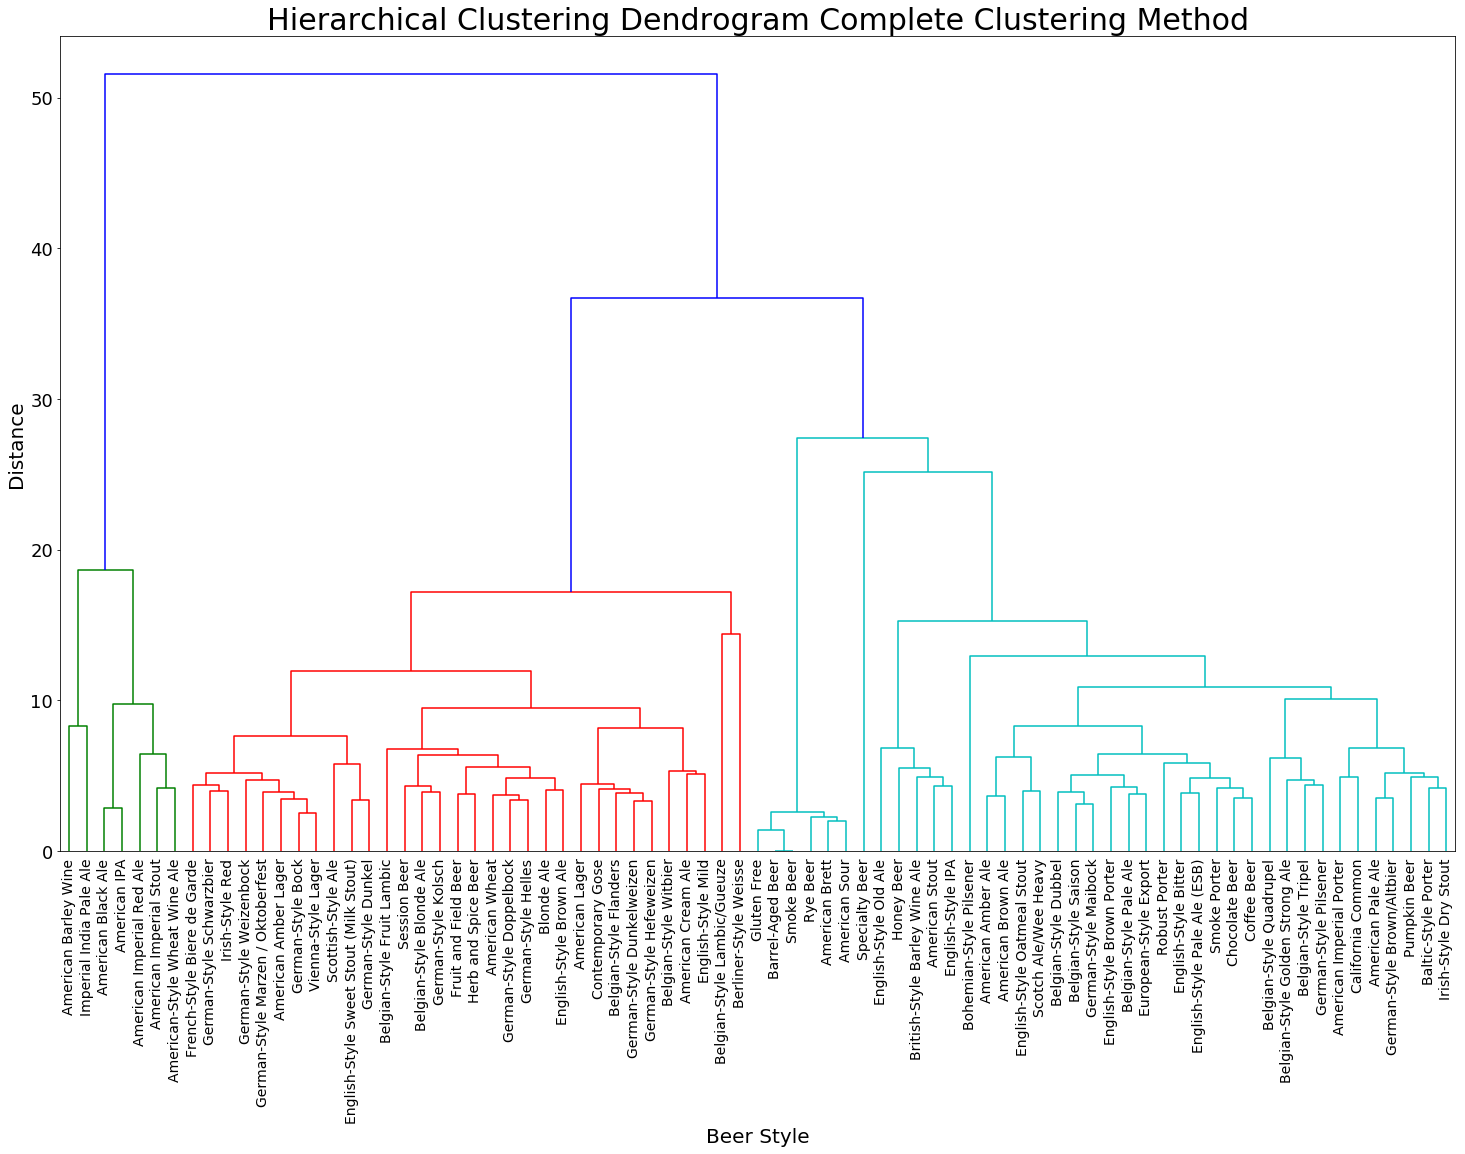

Cophenetic Correlation Coefficient using median clustering method is 0.76.


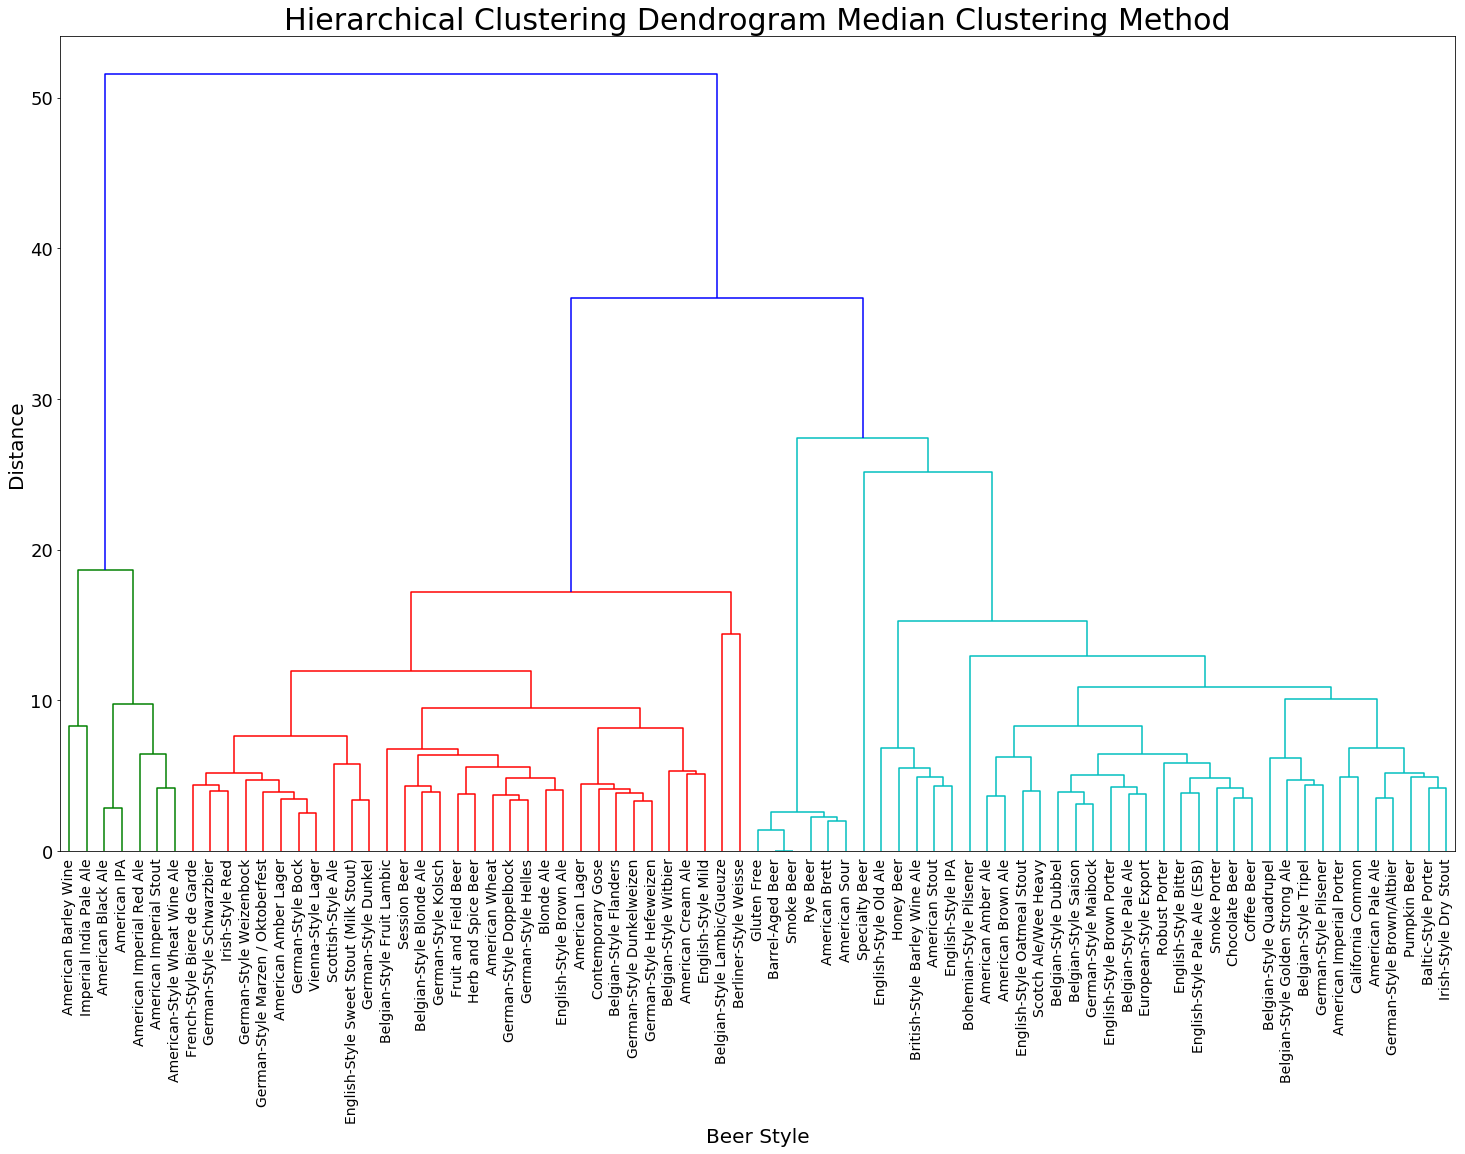

Cophenetic Correlation Coefficient using single clustering method is 0.59.


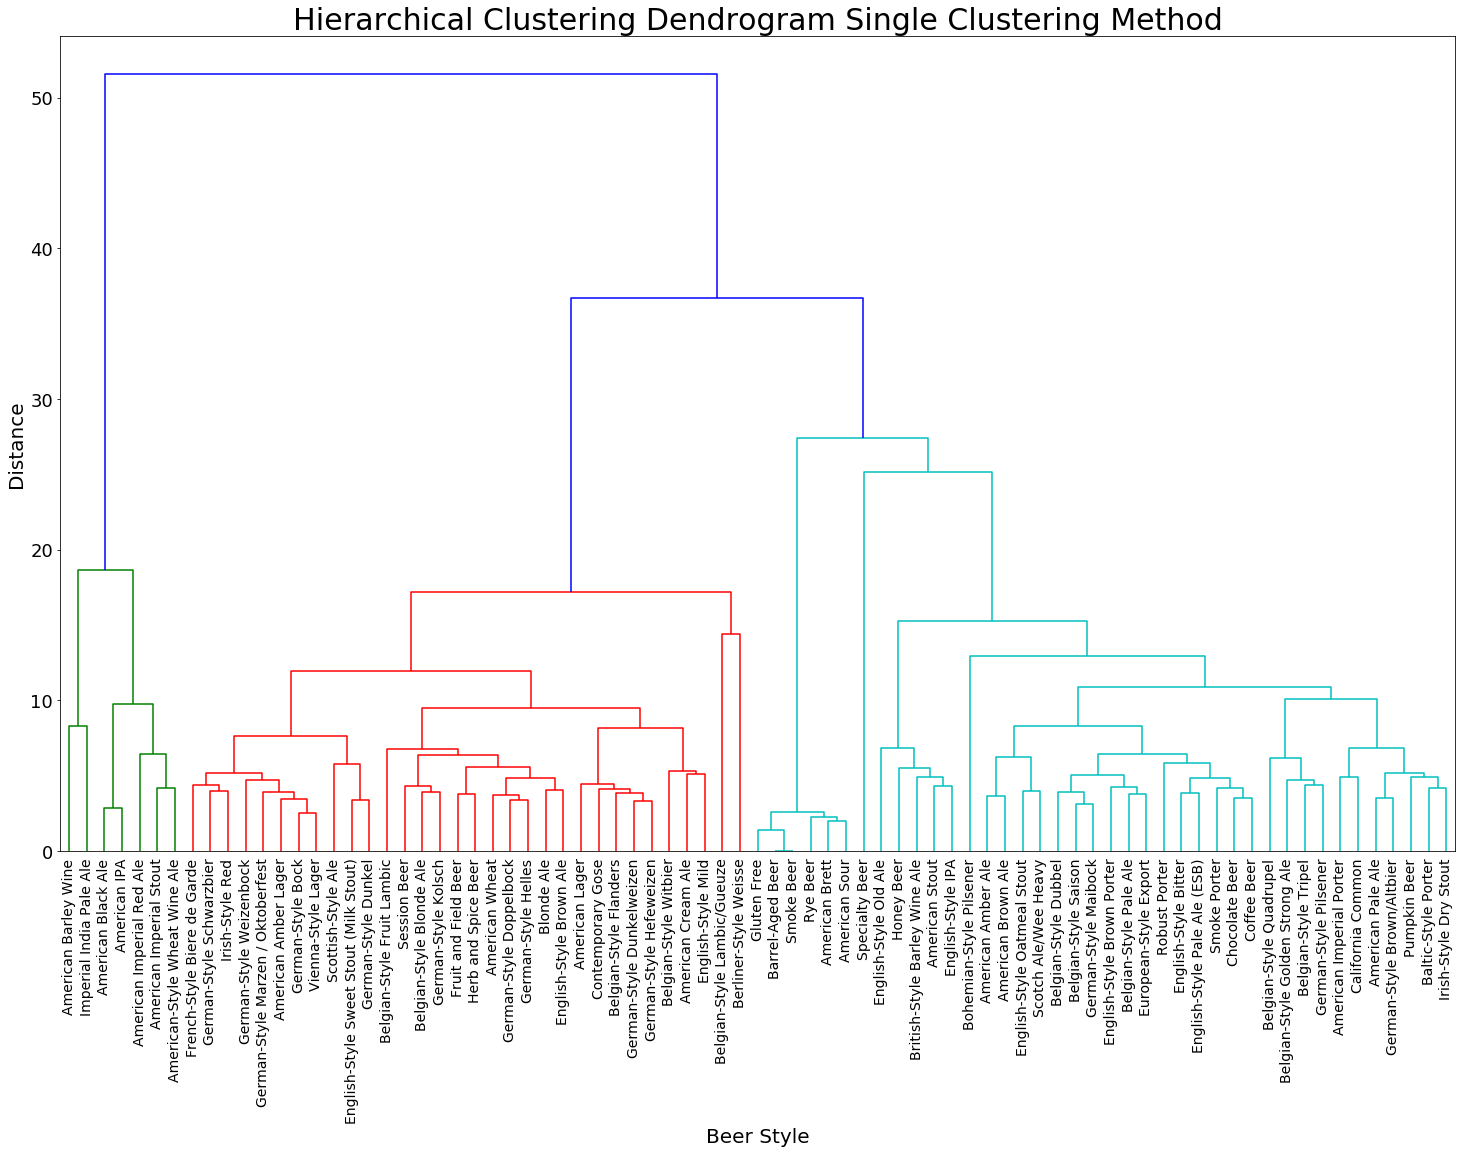

Cophenetic Correlation Coefficient using weighted clustering method is 0.69.


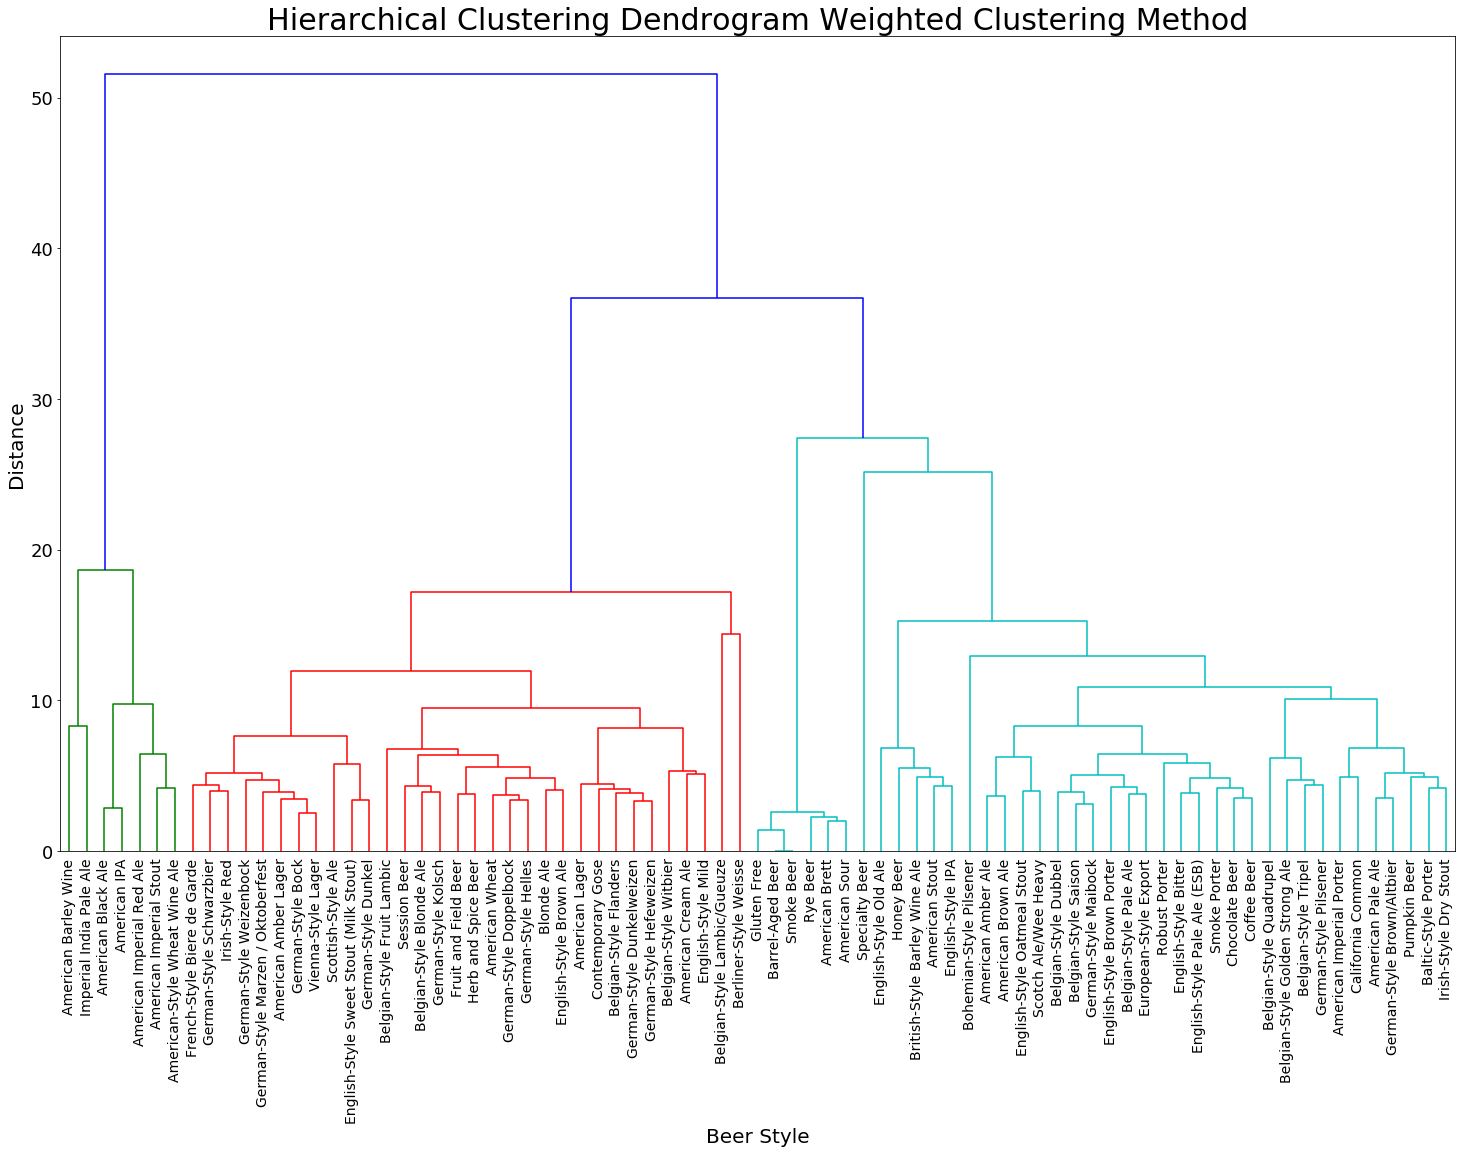

In [280]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster

##Hierarchical Clustering and Plot Dendrogram

def cluster(metrics):
    fit = linkage(df, metrics)
    c, coph_dists = cophenet(fit, pdist(df))
    print('Cophenetic Correlation Coefficient using {} clustering method is {:.2f}.'.format(metrics,c)) 
    
    fig = plt.figure(figsize=(25, 15))
    ax = fig.add_subplot(111)

    dendrogram(ward, leaf_rotation=90., leaf_font_size=8.)
    title = 'Hierarchical Clustering Dendrogram ' + metrics.capitalize() + ' Clustering Method'
    plt.title(title,fontsize = 30)
    plt.xlabel('Beer Style',fontsize = 20)
    plt.ylabel('Distance',fontsize = 20)
    plt.yticks(fontsize=18)
#     plt.plot([0, 10000], [max_d, max_d], 'k--')

    #Change Xticks Labels
    xticks_txt = ' '.join(label.get_text() for label in ax.get_xticklabels()).split(' ')
    xticks_inx = []
    xticks_value = []
    for i in xticks_txt:
        xticks_inx.append(int(i))

    for i in xticks_inx:
        xticks_value.append(df.index.values[i])
    
    ax.set_xticklabels(xticks_value, fontsize = 14)

    plt.show()
    return fit

linkage_metrics = ['average','centroid','ward','complete','median','single','weighted']

for i in range(len(linkage_metrics)):
    cluster(linkage_metrics[i])

Cophenetic Correlation Coefficient using average clustering method is 0.85.


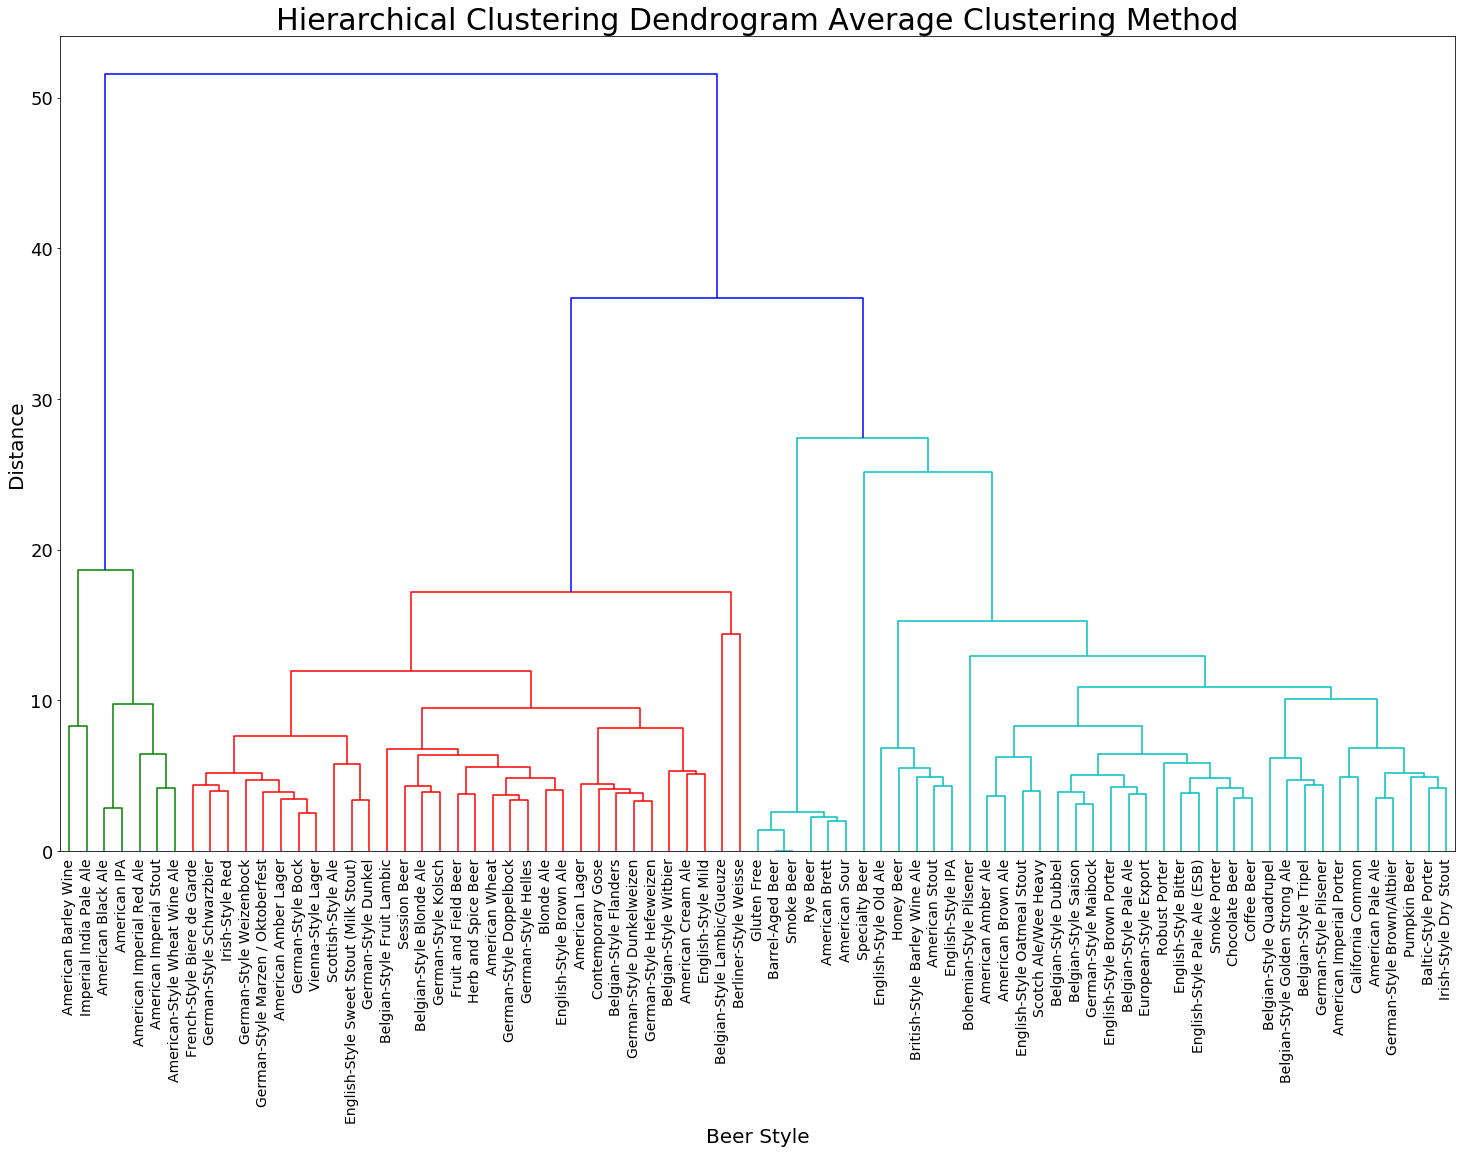

Cluster 1 contains 2 beer styles:
 ['American Barley Wine', 'Imperial India Pale Ale']

Cluster 2 contains 5 beer styles:
 ['American Black Ale', 'American IPA', 'American Imperial Red Ale', 'American Imperial Stout', 'American-Style Wheat Wine Ale']

Cluster 3 contains 5 beer styles:
 ['American Stout', 'British-Style Barley Wine Ale', 'English-Style IPA', 'English-Style Old Ale', 'Honey Beer']

Cluster 4 contains 11 beer styles:
 ['American Imperial Porter', 'American Pale Ale', 'Baltic-Style Porter', 'Belgian-Style Golden Strong Ale', 'Belgian-Style Quadrupel', 'Belgian-Style Tripel', 'California Common', 'German-Style Brown/Altbier', 'German-Style Pilsener', 'Irish-Style Dry Stout', 'Pumpkin Beer']

Cluster 5 contains 1 beer styles:
 ['Bohemian-Style Pilsener']

Cluster 6 contains 38 beer styles:
 ['American Amber Ale', 'American Amber Lager', 'American Brown Ale', 'American Wheat', 'Belgian-Style Blonde Ale', 'Belgian-Style Dubbel', 'Belgian-Style Fruit Lambic', 'Belgian-Style Pal

In [285]:
#Retrieve Clusters
max_d = 10 #Can be adjusted

clusters = fcluster(cluster('average'), max_d, criterion='distance')
df_clusters = pd.DataFrame(clusters, columns = ['Cluster'])
clusters_list = []

for i in range(min(clusters),max(clusters)+1):
    for j in np.where(clusters == i):
        print('Cluster {} contains {} beer styles:\n {}\n'.format(i,len(df.index[j].tolist()),df.index[j].tolist()))